# Linear Regression Using Bayesian Hierarchical and Mixture Modelling

#### Author: Ryan Rubenzahl

A sandbox to play with the linear regression model described in Kelly (2007). The majority of the text is restatements of the relevant sections in Kelly (2007).

https://arxiv.org/abs/0705.2774

The method incorporates:
- heteroscedastic and possibly correlated measurement errors in both the dependent and independent variables
- intrinsic scatter in the dependent variable
- non-detections/upper limits
- selection effects on the measurements.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
mpl.rc('font', family='sans serif', size=14)

### True quantities, where intrinsic scatter exists in the dependent variable

We assume a a single independent variable for this exercise (Section 4.3 generalizes to multiple independent variables), and define

$\xi$ = independent variable, drawn from $p(\xi | \psi)$

$\eta$ = dependent variable, drawn from $p(\eta | \xi, \theta)$

Joint distribution of $\xi$ and $\eta$ is then $p(\xi, \eta | \psi, \theta) = p(\eta|\xi, \theta)p(\xi | \psi) $

We assume a linear regression model, given by
$$ \eta_i = \alpha + \beta \xi_i + \epsilon_i \tag{1} $$
where $\epsilon_i$ represents the intrinsic scatter (assumed to have mean of zero and constant variance $\sigma^2$). In this case, 
$$ p(\eta | \xi, \theta) = N(\alpha + \beta\xi, \sigma^2), \quad \theta = (\alpha, \beta, \sigma^2) $$

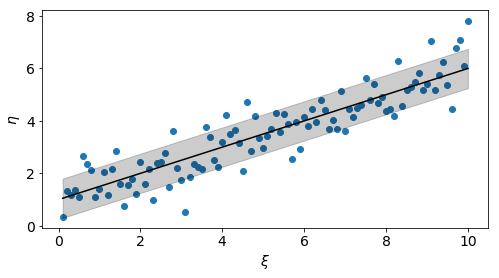

In [4]:
# True independent variable (e.g. planet radius)
Nobs = 100
xi = np.linspace(0.1, 10, Nobs)

# Linear regression (model) and parameters (theta)
def model(xi, theta):
    alpha, beta, sigma_sq = theta
    
    # Intrinsic scatter
    epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma_sq),
                                  size=xi.shape)
    
    return alpha + beta*xi + epsilon

# Parameter values
alpha = 1.0
beta  = 0.5
sigma_sq = 0.75**2
theta = np.array([alpha, beta, sigma_sq])

# True dependent variable (e.g. planet mass) from model
eta = model(xi, theta)

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.set(xlabel=r'$\xi$', ylabel=r'$\eta$')
ax.scatter(xi, eta)

# Show the true model
ax.plot(xi, alpha + beta*xi, color='k')
ax.fill_between(xi, alpha + beta*xi + np.sqrt(sigma_sq),
                alpha + beta*xi - np.sqrt(sigma_sq), 
                color='k', alpha=0.2)

### Measured quantities

When we conduct an experiment, we measure the parameters $\xi$ and $\eta$ with error, and the measured values are denoted by
$$ x_i = \xi_i + \epsilon_{x,i} \tag{2} $$
$$ y_i = \eta_i + \epsilon_{y,i} \tag{3} $$
$\epsilon_{x,i}$ and $\epsilon_{y,i}$ are the random measurement errors in $x_i$ and $y_i$. In general these errors are normally distributed with known variances $\sigma_{x,i}^2$ and $\sigma_{y,i}^2$, and covariance $\sigma{xy,i}$.

In general, these errors may be heteroscedastic.

<ErrorbarContainer object of 3 artists>

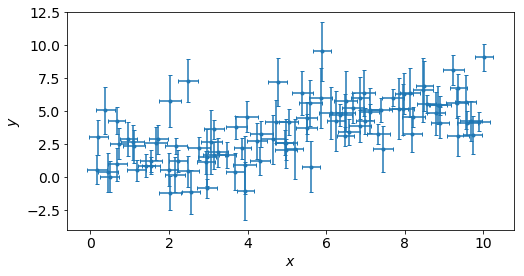

In [5]:
# Our measurement parameters introduce another layer
# of randomness, in the form of measurement errors

# The independent variable has an associated measurement error
# sigma_x = np.zeros_like(xi) + 0.2 # homoscedastic errors
sigma_x = stats.truncnorm.rvs(0.1, 1, loc=0.2, 
                              scale=0.1, size=xi.shape) # heteroscedastic
epsilon_x = np.random.normal(scale=sigma_x, size=xi.shape)
x = xi + epsilon_x

# As does our measurements of the dependent variable
# sigma_y = np.zeros_like(eta) + 0.5 # homoscedastic errors
sigma_y = stats.truncnorm.rvs(0.1, 2, loc=0.5, 
                              scale=1, size=xi.shape) # heteroscedastic
epsilon_y = np.random.normal(scale=sigma_y, size=eta.shape)
y = eta + epsilon_y

# Can also implement covariance, but here we assume none
sigma_xy = np.zeros_like(x) + 0

# Error matrix to store all these
xy_err = np.asarray([[sigma_x, sigma_xy],
                     [sigma_xy, sigma_y]])

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.set(xlabel=r'$x$', ylabel=r'$y$')
ax.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, 
            fmt='.', capsize=2)

## The likelihood function

The likelihood function of the measured data is obtained by integrating the joint data likelihood over the true parameters
$$ p(x,y | \theta,\psi) = \int\int p(x,y,\xi,\eta|\theta,\phi)d\xi d\eta \tag{10} $$
We can decompose this in terms of our hierarchical model as
$$ p(x,y | \theta,\psi) = \int\int p(x,y |\xi,\eta)p(\eta|\xi, \theta) p(\xi | \psi) d\xi d\eta \tag{11} $$
Assuming Gaussian measurement errors $(\epsilon_x, \epsilon_y)$, the joint distribution of the measured values, $p(x,y|\xi,\eta)$, is a multivariate normal distribution. We can summarize all this in a hierarchical statistical model:
$$ \xi_i \sim p(\xi | \psi) \tag{12} $$
$$ \eta_i | \xi_i \sim N(\alpha + \beta\xi_i, \sigma^2) \tag{13} $$
$$ x_i, y_i | \xi_i, \eta_i \sim N_2([\eta_i,\xi_i], \Sigma_i)  \tag{14} $$
where $\Sigma_i$ is the covariance matrix representing the $i^{th}$ $(x_i, y_i)$ measurement pair uncertainties. 

### Gaussian mixture model for the independent variable

We model $p(\xi | \psi)$ as a mixture of $K$ Gaussians as such:
$$ p(\xi_i, \psi) = \sum_{k=1}^K \frac{\pi_k}{\sqrt{2\pi\tau_k^2}}\exp\left(-\frac{1}{2}\frac{(\xi_i-\mu_k)^2}{\tau_k^2}\right), \quad \sum_{k=1}^K \pi_k = 1 \tag{15}$$
$\pi_k$ may be thought of as the probability of drawing a data point from the $k^{th}$ Gaussian. This mixture model nicely adapts to any arbitrary distribution of $\xi$, as well as simplifies the mathematics. Under this prescription,
$$ \psi = (\pi, \mu, \tau^2) $$
are the [mixture model](https://en.wikipedia.org/wiki/Mixture_model) parameters. This is a useful for representing subpopulations within the overall population of $\xi$, and as $K$ increases the model adapts to any arbitrary underlying distribution in $\xi$.

In [6]:
def prob_xi_given_psi(xi, psi):
    '''
    Models the distribution of the independent variable
    as a mixture of K Gaussians (Equation 15)
    '''
    
    K = len(psi) # number of mixture models
    
    if K > 1:
        pi   = psi[:,0]
        mu   = psi[:,1]
        tau2 = psi[:,2]

        norm = (pi / np.sqrt(2*np.pi*tau2))

        return [np.sum(norm*np.exp(-0.5*(xi[i]-mu)**2/tau2)) 
                for i in range(len(xi))]

    elif K == 1:
        pi, mu, tau2  = psi

        norm = (pi / np.sqrt(2*np.pi*tau2))

        return norm*np.exp(-0.5*(xi - mu)**2 / tau2)
    else:
        return 1

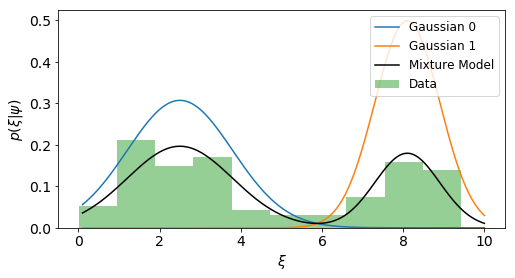

In [7]:
# Consider a mixture model of K=2 Gaussians

                # pi, mu, tau2
# psi = np.array([[0.3, 1.3, 0.3**2],
#                 [0.7, 2.6, 0.8**2]])
psi = np.array([[0.64, 2.5, 1.3**2],
                [0.36, 8.1, 0.8**2]])

xi_all = np.linspace(0.1,10, 10000)

fig, ax = plt.subplots(1,1, figsize=(8,4))
for i in range(len(psi)):
    pi, mu, tau2 = psi[i]
    
    ax.plot(xi_all, stats.norm.pdf(xi_all,
                              loc=mu,
                              scale=np.sqrt(tau2)),
                              label='Gaussian %d' % i)
    
# Generate a population using this mixture model
def mixture_population(N, psi, limits=None):
    xi_gmm = []

    for i in range(N):

        n = np.random.rand()
        
        # Assumes 2-Gaussian model currently...
        if n < psi[0][0]:
            # 1st Gaussian
            pi, mu, tau2 = psi[0]
        else:
            # 2nd Gaussian
            pi, mu, tau2 = psi[1]

        sigma = np.sqrt(tau2)
        if limits == None:
            xi_draw = np.random.normal(loc=mu, scale=sigma)
        else:
            # Truncated normal distribution
            lower, upper = limits
            xi_draw = stats.truncnorm.rvs((lower-mu)/sigma,
                                          (upper-mu)/sigma,
                                        loc=mu, scale=sigma)
      
        xi_gmm.append(xi_draw)
        
    return np.array(xi_gmm)

xi_gmm = mixture_population(100, psi, limits=[0,10])
    
plt.hist(xi_gmm, density=1, alpha=0.5, label='Data')
ax.plot(xi_all, prob_xi_given_psi(xi_all, psi), color='k',
           label='Mixture Model')

ax.set(xlabel=r'$\xi$', ylabel=r'$p(\xi | \psi)$')
ax.legend(loc='upper right', fontsize=12)

Now we can generate a new dataset, where the independent variable has some arbitrary underlying distribution (previously, we were assuming a uniform distribution by using np.linspace)

<ErrorbarContainer object of 3 artists>

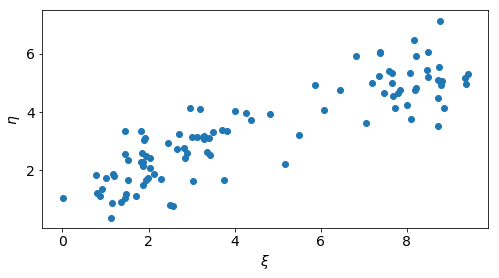

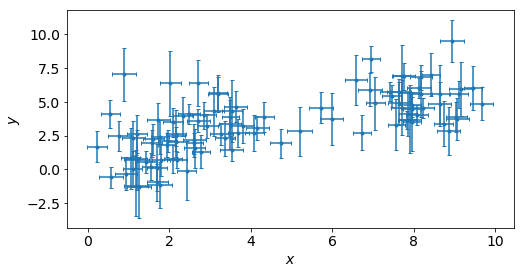

In [8]:
# True independent variable (e.g. planet radius)
xi = np.array(xi_gmm)

# True dependent variable (e.g. planet mass) from model
eta = model(xi, theta)

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.set(xlabel=r'$\xi$', ylabel=r'$\eta$')
ax.scatter(xi, eta)

# The independent variable has an associated measurement error
epsilon_x = np.random.normal(scale=sigma_x, size=xi.shape)
x = xi + epsilon_x

# As does our measurements of the dependent variable
epsilon_y = np.random.normal(scale=sigma_y, size=eta.shape)
y = eta + epsilon_y

# Can also implement covariance, but here we assume none
sigma_xy = 0

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.set(xlabel=r'$x$', ylabel=r'$y$')
ax.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, 
            fmt='.', capsize=2)

### Include non-detections (upper-limits)

In some cases, the data may include upper-limits on the measured dependent variable. Here I generate some 95% upper-limits that can be included in the data.

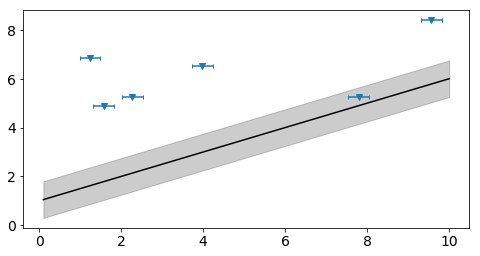

In [9]:
# Draw 6 cases in which we will measure upper-limits (UL)
xi_nondet  = mixture_population(6, psi)
eta_nondet = model(xi_nondet, theta)

# Make the measurement of the independent variable
e_x_nondet = np.random.normal(scale=np.mean(sigma_x),
                              size=xi_nondet.shape)
x_nondet = xi_nondet + e_x_nondet

# Our measurement of the dependent variable is a 95% UL
# The 95th %ile corresponds to ~1.64485*sigma above the mean
e_y_nondet = np.random.normal(loc=1.64485*np.mean(sigma_y),
                              scale=1.64485*np.mean(sigma_y),
                              size=eta_nondet.shape)
y_nondet = eta_nondet + np.abs(e_y_nondet)

fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.errorbar(x_nondet, y_nondet, xerr=np.mean(sigma_x), 
            fmt='.', marker='v', capsize=2)

ax.plot(xi_all, alpha + beta*xi_all, color='k')
ax.fill_between(xi_all, 
                alpha + beta*xi_all + np.sqrt(sigma_sq),
                alpha + beta*xi_all - np.sqrt(sigma_sq), 
                color='k', alpha=0.2)


## Measured data likelihood

The observed data likelihood for the measured data, $\mathbf{z} = (y, x)$, from the integral above, can now be directly computed as a mixture of bivariate normal distributions with weights $\pi$, means $\zeta = (\zeta_1,...\zeta_K)$, and covariance matrices $V_i = (V_{1,i},...V_{K,i})$.
$$ p(x,y | \theta,\psi) = \prod_{i=1}^n \sum_{k=1}^K \frac{\pi_k}{2\pi|V_{k,i}|^{1/2}} \exp\left[-\frac{1}{2}(\mathbf{z}_i - \zeta_k)^T V_{k,i}^{-1}(\mathbf{z}_i - \zeta_k) \right] \tag{16} $$
where
$$ \zeta_k = (\alpha + \beta \mu_k, \mu_k) \tag{17} $$
and
$$ V_{k,i} = \begin{pmatrix} \beta^2\tau_k^2 + \sigma^2 + \sigma_{y,i}^2 & \beta\tau_k^2 + \sigma_{xy,i} \\
\beta^2\tau_k^2 + \sigma_{xy,i} & \tau_k^2 + \sigma_{x,i}^2 \end{pmatrix} \tag{18} $$
(the product is because each observation is statistically independent)

Eq. 16 can be maximized to find the maximum-likelihood estimate (MLE) of the parameters $\theta, \psi$.

__Note:__ The "usual" assumption of a uniform prior in the independent variable, $p(\xi | \psi) \propto 1$, can be obtained from taking $\tau^2 \rightarrow \infty$. It can be shown that doing so simply recovers the ordinary least-squares estimators. In ordinary least squares, the regression estimators are biased (e.g. slope is biased towards zero) in the presence of measurement uncertainties, and making the above assumption thus inherits that bias.

In general, the independent variable is not drawn from a uniform distribution, and so this assumption is incorrect anyway.

In [10]:
# Function to compute log-likelihood?

### Prior densities

#### Uniform Prior

Uniform priors are adopted for the regression parameters $\theta = (\alpha, \beta, \sigma^2)$.

$$ p(\theta) = \text{Uniform}(\theta_{min}, \theta_{max}) =  \frac{1}{\theta_{max} - \theta_{min}}$$ 

Note that if $\theta_{min}$ and $\theta_{max}$ are unknown, then $p(\theta)$ is an _improper_ prior. In such a case it may still be used for parameter estimation, so long as the posterior is normalized, but not for model selection.

#### Mixture parameters

The mixture parameters have a slightly different treatment. The coefficients $\pi_k$ are drawn from
$$ \pi_1, ..., \pi_K \sim \text{Dirichlet}(1, ..., 1) $$
The Dirichlet density is simply a uniform prior over each $\pi_k$ while maintaining the constraint $\sum_{k=1}^K \pi_k = 1$.

The mean of each Gaussian, $\mu_k$, will be taken from a normal prior with mean $\mu_0$ and variance $u^2$ (or covariance matrix $U$)
$$ \mu_k \sim N(\mu_0, u^2) $$
For the variances of the mixture Gaussians, as well as teh variance of the prior on the mean just described ($u^2$), a scaled inverse-$\chi^2$ prior with scale parameter $w^2$ and 1 degree of freedom is used
$$ \tau_1^2, ..., \tau_K^2, u^2 | w^2 \sim \text{Inv-}\chi^2(1, w^2)$$
The parameters defining the prior densities, $\mu_0, u^2, w^2$, are known as _hyper-parameters_ and are left free in the optimization. Uniform priors on these are therefore assumed. (Note the same hyperparameter $w^2$ defines both the priors in $\tau^2_k$ and $u^2$.)

### Hierarchical summary of priors

The prior on the parameters is
$$ p(\theta, \psi, \mu_0, u^2, w^2) = p(\alpha)p(\beta)p(\sigma^2)p(\pi)p(\mu|\mu_0,u^2)p(\tau^2|w^2)p(u^2|w^2)p(\mu_0)p(w^2) $$
where
\begin{align}
\alpha, \beta &\sim \text{Uniform}(-\infty, \infty) \\
     \sigma^2 &\sim \text{Uniform}(-0, \infty) \\
          \pi &\sim \text{Dirichlet}(1,...,1) \\
\mu_1,...,\mu_K | \mu_0, u^2 &\sim \text{N}(\mu_0, u^2) \\
\tau^2_1,...,\tau^2_K, u^2 | w^2 &\sim \text{Inv-}\chi^2(1, w^2) \\
    \mu_0 &\sim \text{Uniform}(-\infty, \infty) \\
    w^2   &\sim \text{Uniform}(-0, \infty) \\
\end{align}

Since the uniform priors are merely constants, we can write
$$ p(\theta, \psi, \mu_0, u^2, w^2) \propto p(\pi)p(\mu|\mu_0,u^2)p(\tau^2|w^2)p(u^2|w^2) $$

# Calculating the Maximum Likelihood Estimate

For $K > 1$, the MLE is most efficiently computed using an [expectation-maximization](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm#Gaussian_mixture) (EM) algorithm. A Markov Chain with Gibbs sampling, or the Metropolis-Hastings MCMC can also be used.

The method of Roy & Banerjee (2006), which assumes $p(\xi)$ is a mixture of normals and the measurement error distribution is mutlivariate $t$, is used in Kelly's statistical model. 

## Gibbs sampler for the Gaussian mixture model

The Gibbs sampler constructs a Markov chain where at each iteration new values for the model parameters and missing data are simulated, given the values of the observed data and the current model parameter/missing data values. The sampler eventually converges, and new draws may be taken as samples from the posterior distribution.

This proceeds in four stages:
1. Simulate values of the missing data, given the measured data and current parameter values
    - Also introduce the latent variable $G_{ik}$ to specify class membership for the $i^{th}$ data point to the $k^{th}$ Gaussian
2. Simulate values of the regression parameters, $\theta$, given the current values of $\xi$ and $\eta$
3. Simulate values of the mixture parameters, $\psi$, given the current values of $\xi$ and $\eta$
4. Use the new values of $\theta$ and $\psi$ to update the parameters of the prior density

The values of the parameters are saved at each iteration, and after many iterations the Markov chain will converge, at which point the results of stage 2 and 3 may be treated as "draws" from the posterior distribution $p(\theta, \psi | x, y)$.

## Run the sampler on the data

In [11]:
from importlib import reload

In [12]:
# I have written and saved the functions to run 
# the Gibbs sampler in a separate python file
import gibbs_sampler
reload(gibbs_sampler)
from gibbs_sampler import gibbs

# Initialize model and mixture parameters
eta_init   = np.ones_like(eta)
theta_init = np.array([0,0,1]) # alpha, beta, sigma^2
psi_init   = np.asarray([[0.5,0,1],[0.5,0,1]]) # pi, mu, tau^2

# Initialize all the Gs to the first Gaussian
G_init = np.zeros((len(x), psi_init.ndim))
G_init[:,0] += 1

# Initial hyperparameters for the priors
hypers = [1, 1, 1] # mu0, u^2, w^2

init = [theta_init, psi_init, G_init, eta_init]

num_iters = 10000

# Run the sampler
df = gibbs(x, y, xy_err, init, hypers, num_iters)

9901 / 10000

### Check the convergence of the sampler

See if there is a significant 'burn-in' time, and if so remove those samples. (can add more sophisticated convergence monitoring later)

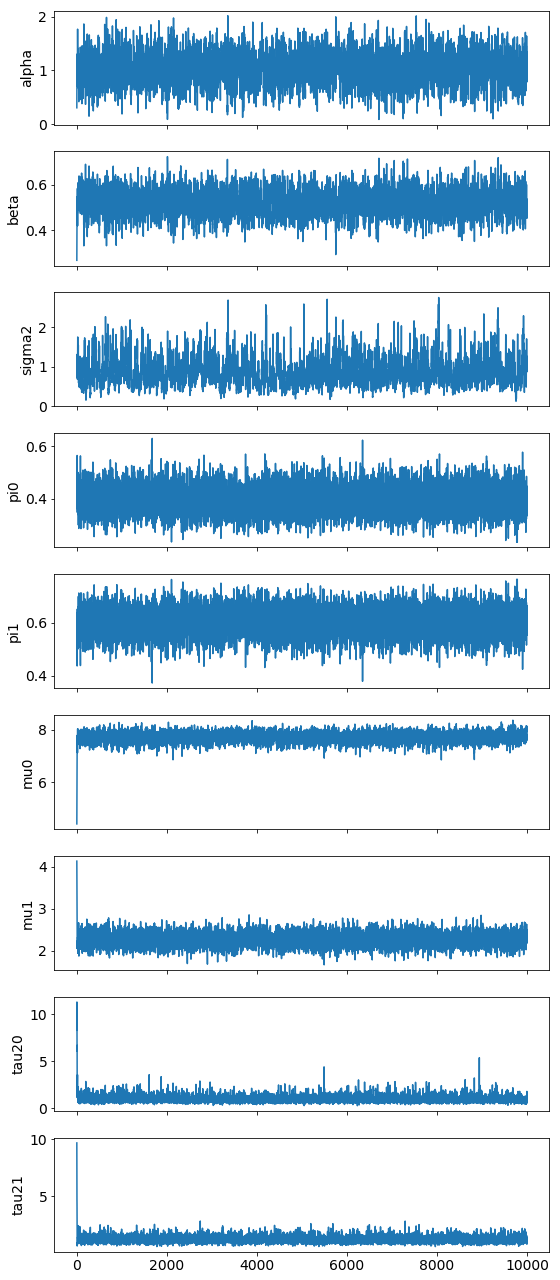

In [13]:
nparam = 9

fig, axes = plt.subplots(nparam,1, figsize=(8,2*nparam),
                        sharex=True)

for i, ax in enumerate(axes):
    ax.plot(df[df.columns[i]])
    
    ax.set(ylabel=df.columns[i])
    
    if i == nparam:
        ax.set(xlabel='Iteration')
        
fig.tight_layout()

In [14]:
# Cut out the burn-in
df = df[100:]

### Corner plots!!

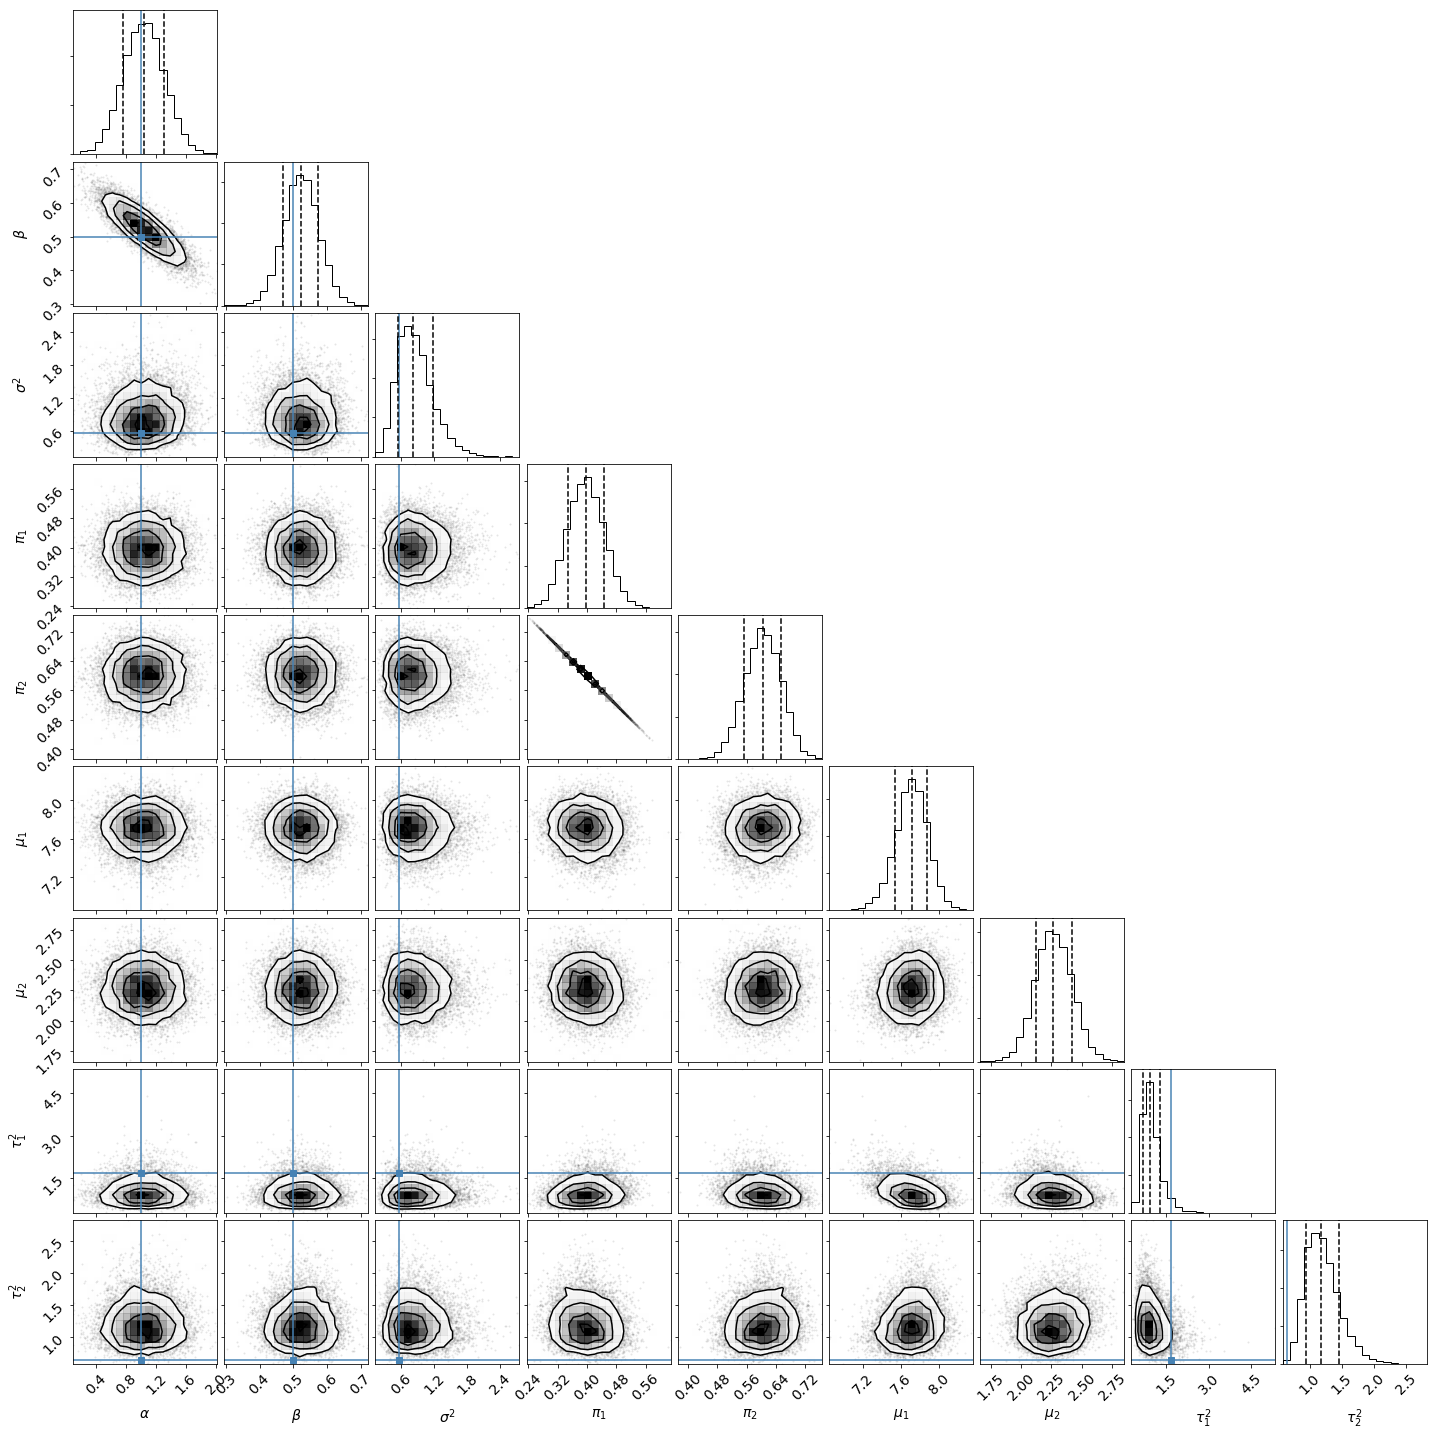

In [15]:
import corner

labels=[r'$\alpha$', r'$\beta$', r'$\sigma^2$',
                      r'$\pi_1$', r'$\pi_2$', r'$\mu_1$',
                      r'$\mu_2$', r'$\tau^2_1$', r'$\tau^2_2$'
                     ]

figure = corner.corner(df[df.columns[:nparam]], labels=labels,
                       quantiles=[0.16, 0.5, 0.84],
                       truths=[alpha, beta, sigma_sq,
                              *psi.T.flatten()]
                      )

In [16]:
# Compare to ordinary least squares
import scipy.optimize as opt

def f(params, x):
    return params[0] + x*params[1]

def chi2(params, x):
    return np.sum((y - f(params, x))**2 / 4**2)


res = opt.minimize(chi2, [0,0], args=(x))
res

      fun: 17.41687740758163
 hess_inv: array([[ 0.26946599, -0.04194302],
       [-0.04194302,  0.00929246]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([1.16005172, 0.49775748])

# Show the best fit model with the data

In [17]:
alpha50  = np.percentile(df['alpha'], 50)
beta50   = np.percentile(df['beta'], 50)
sigma_50 = np.percentile(np.sqrt(df['sigma2']), 50)

fit_x = np.linspace(np.min(x), np.max(x))

fit_y50 = alpha50 + beta50*fit_x
fit_yup = fit_y50 + sigma_50
fit_ylo = fit_y50 - sigma_50

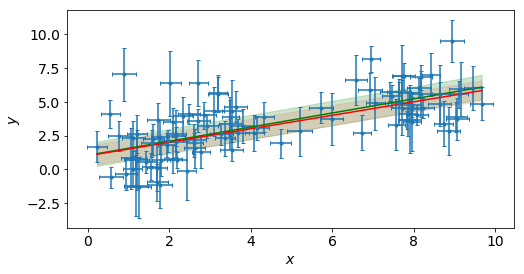

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.set(xlabel=r'$x$', ylabel=r'$y$')
ax.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='.', capsize=2)

# Plot the best-fit median model
c = 'g'
ax.plot(fit_x, fit_y50, color=c)
ax.fill_between(fit_x, fit_ylo, fit_yup, color=c, alpha=0.2)

# Also show the true model?
c = 'r'
ax.plot(fit_x, alpha + beta*fit_x, color=c)
ax.fill_between(fit_x, alpha + beta*fit_x - np.sqrt(sigma_sq), 
                       alpha + beta*fit_x + np.sqrt(sigma_sq), 
                       color=c, alpha=0.1)

## Plot prediction confidence interval

Instead of just showing the average model, show the 95% confidence intervals on the model.

In [19]:
def prediction_interval(x, intervals):
    y_interval = []

    for xp in x:

        y_preds = df['alpha'] + df['beta']*xp
        y_percentiles = np.percentile(y_preds, intervals)
        y_interval.append(y_percentiles)

    return np.array(y_interval)

y_68 = prediction_interval(fit_x, [16, 50, 84])
y_95 = prediction_interval(fit_x, [2.5, 50, 97.5])

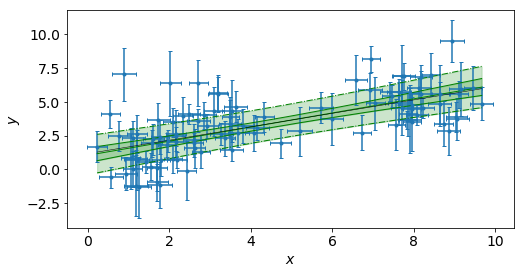

In [27]:
y_interval = y_95

fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.set(xlabel=r'$x$', ylabel=r'$y$')
ax.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='.', capsize=2)

# Plot the central confidence interval of best-fit model
c = 'g'
ax.plot(fit_x, y_interval[:,0], color=c, lw=1, ls='-')
ax.plot(fit_x, y_interval[:,1], color=c, lw=1)
ax.plot(fit_x, y_interval[:,2], color=c, lw=1, ls='-')
ax.fill_between(fit_x, y_interval[:,0], y_interval[:,2], 
                color=c, alpha=0.2)

# And with the best-fit intrinsic scatter added in
ax.plot(fit_x, y_interval[:,0] - sigma_50, color=c, lw=1, ls='-.')
ax.plot(fit_x, y_interval[:,2] + sigma_50, color=c, lw=1, ls='-.')
ax.fill_between(fit_x, y_interval[:,0] - sigma_50, 
                       y_interval[:,2] + sigma_50, color=c, alpha=0.2)

# Also show the true model?
# c = 'r'
# ax.plot(fit_x, alpha + beta*fit_x, color=c)
# ax.fill_between(fit_x, alpha + beta*fit_x - np.sqrt(sigma_sq), 
#                        alpha + beta*fit_x + np.sqrt(sigma_sq), 
#                        color=c, alpha=0.2)


# Plot the ordinary least-squares estimate line
ax.plot(fit_x, f(res.x, fit_x), color='k', lw=0.5)

## Plot best-fit mixture model

Display the best-fit mixture model with the true distribution for the independent variable.

In [21]:
pi0  = np.percentile(df['pi0'], [16, 50, 84])
pi1  = np.percentile(df['pi1'], [16, 50, 84])
mu0  = np.percentile(df['mu0'], [16, 50, 84])
mu1  = np.percentile(df['mu1'], [16, 50, 84])
tau0 = np.percentile(np.sqrt(df['tau20']), [16, 50, 84])
tau1 = np.percentile(np.sqrt(df['tau21']), [16, 50, 84])

psi_fit = np.array([[pi0, mu0, tau0],
                    [pi1, mu1, tau1]])

[Text(0, 0.5, 'p(x)'), Text(0.5, 0, 'x')]

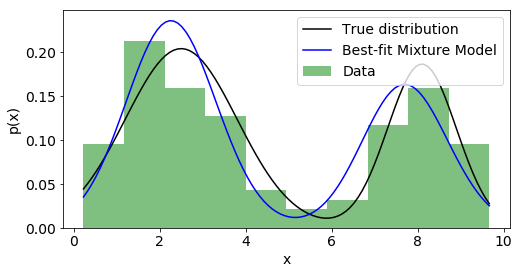

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

x_plot = np.linspace(np.min(x), np.max(x), 100)

model_gmm = prob_xi_given_psi(x_plot, psi)
model_norm = np.trapz(model_gmm, x_plot)
ax.plot(x_plot, model_gmm/model_norm, color='k',
           label='True distribution')

fit_gmm  = prob_xi_given_psi(x_plot, psi_fit)
fit_norm = np.trapz(fit_gmm, x_plot)
ax.plot(x_plot, fit_gmm / fit_norm, color='b',
           label='Best-fit Mixture Model')

ax.hist(x, density=1, color='g', alpha=0.5, label='Data')
ax.legend(loc='upper right')

ax.set(xlabel='x', ylabel='p(x)')